In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import seaborn as sns
from copy import deepcopy


In [2]:
pprint(wn.synset('bound.a.01').mst(lambda s:s.also_sees()))

Pretty printing has been turned OFF


## Group results besed on their hops connected in WordNet
1. coverage of WordNet 
2. Performance of each group (2-hop, vs >2-hops)

# Get hops of connecting hpyonym-hypernym

In [3]:
from nltk.corpus import wordnet as wn

def get_path_using_hypernym_dict(hypernym,hypernym_dict,synsets):
    '''
    Return the path between a sense and a specified hypernym 
    Core idea: starting from the hypernym, find its child sense (iterate this process, DFS)
    
    hypernym: a synset, which is a hypernym   
    hypernym_dict: a {hypernym: sense} dict 
    sensets: a synsets 
    '''
    
    path = [hypernym]
    current_synset = hypernym_dict[hypernym]
  
    while current_synset not in synsets: #stop criteria: when find a sense belonging to the synsets
        path.append(current_synset)
        current_synset =  hypernym_dict[current_synset]
    path.append(current_synset)
    return path
    
# hypernym_dict = get_hypernym_path_dict(wn.synsets("book","n"))
# print(get_path_using_hypernym_dict(wn.synset('physical_entity.n.01'),hypernym_dict,wn.synsets("book","n")))
        

def get_hypernym_path_dict(synsets):
    '''
    get the hypernyms for all synsets of a given word 
    return hypernym_dict: key is the hypernym and value is the synset
    '''
    hypernym_dict = {}
    synsets_to_expand = synsets
    while synsets_to_expand:
        new_synsets_to_expand = set()
        for synset in synsets_to_expand:
            for hypernym in synset.hypernyms():
                if hypernym not in hypernym_dict:  # this ensures we get the shortest path
                    hypernym_dict[hypernym] = synset
                    new_synsets_to_expand.add(hypernym)
        synsets_to_expand = new_synsets_to_expand
    return hypernym_dict
        
def get_wordnet_shortest_path_between(word1, word2):
    '''
    get the shorttest path betwen two words
    question: what to return if a word is not in the wordnet
    
        #     hypernym_dict1 = get_hypernym_path_dict(synsets1)
    #     hypernym_dict2 = get_hypernym_path_dict(synsets2)
    #     best_path = []
    #     for hypernym in hypernym_dict1:
    #         if hypernym in hypernym_dict2 and hypernym_dict1[hypernym] != hypernym_dict2[hypernym]: #find the LCS
    #             path1 = get_path_using_hypernym_dict(hypernym,hypernym_dict1,synsets1)
    #             path2 = get_path_using_hypernym_dict(hypernym,hypernym_dict2,synsets2)

    #             if not best_path or len(path1) + len(path2) - 1 < len(best_path):
    #                 path1.reverse()
    #                 best_path = path1 + path2[1:]
    #     return best_path
    '''

    synsets1 = wn.synsets(word1, wn.NOUN)
    synsets2 = wn.synsets(word2, wn.NOUN)
    
    if len(synsets1)==0 or len(synsets2) ==0: return [] #retrun [] means no path exsit 
    # added these two lines to catch situation where word1 and word2 share a synset, the distance is 1, 1/path=1
    match = set(synsets1).intersection(set(synsets2))
    if match: return [list(match)[0]]

    paths = []
    for s, t in zip(synsets1, synsets2):
        spd = s.shortest_path_distance(t)
        paths.append(spd)

    best_path = min(paths)
    
    return best_path

    
def get_wordnet_shortest_path_score_between(word1,word2):
    '''
    path_score = 1/short_path_length(word2, word2)
    path_score=0 if word1/word2 is not in wordnet 
    '''
    best_path = get_wordnet_shortest_path_between(word1, word2)    
    return 1/len(best_path) if len(best_path)>0 else 0

    
    
    
# def get_wordnet_shortest_path_length_between(word1,word2, oov_path_len=100):
#     '''
#     oov_path: the path for out-of-vocabulary words
#     '''
#     synsets1 = wn.synsets(word1, wn.NOUN)
#     synsets2 = wn.synsets(word2, wn.NOUN)
    
#     if len(synsets1)==0 or len(synsets2) ==0: return oov_path_len  #retrun [] means no path exsit 
#     # added these two lines to catch situation where word1 and word2 share a synset, the distance is 1, 1/path=1
#     match = set(synsets1).intersection(set(synsets2))
#     if match: return 1

#     paths = []
#     for s, t in zip(synsets1, synsets2):
#         spd = s.shortest_path_distance(t)
#         paths.append(spd)

#     best_path = min(paths)
    
#     return best_path 

def get_wordnet_shortest_path_between(word1,word2):
    '''
    get the shorttest path betwen two words
    question: what to return if a word is not in the wordnet
    '''

    synsets1 = wn.synsets(word1, wn.NOUN)
    synsets2 = wn.synsets(word2, wn.NOUN)
    if len(synsets1)==0 or len(synsets2) ==0: return [] #retrun [] means no path exsit 
    # added these two lines to catch situation where word1 and word2 share a synset, the distance is 1, 1/path=1
    match = set(synsets1).intersection(set(synsets2))
    if match: return [list(match)[0]]

    hypernym_dict1 = get_hypernym_path_dict(synsets1)
    hypernym_dict2 = get_hypernym_path_dict(synsets2)
    best_path = []
    for hypernym in hypernym_dict1:
        if hypernym in hypernym_dict2: # and hypernym_dict1[hypernym] != hypernym_dict2[hypernym]: #find the LCS
            #hypernym_dict1[hypernym] != hypernym_dict2[hypernym] indicate that the two words share the same sense 
            #the != here should be removed, because it exclude the situation of word2 is the hypernym of word1
            path1 = get_path_using_hypernym_dict(hypernym, hypernym_dict1, synsets1)
            path2 = get_path_using_hypernym_dict(hypernym, hypernym_dict2, synsets2)
#             print('path1', path1)
#             print('path2', path2)
            if not best_path or len(path1) + len(path2) - 1 < len(best_path):
                path1.reverse()
                best_path = path1 + path2[1:]
    return best_path

    
def get_wordnet_shortest_path_length_between(word1,word2, oov_path_len=100):
    '''
    oov_path: the path for out-of-vocabulary words
    '''
    best_path = get_wordnet_shortest_path_between(word1, word2)    
    return len(best_path) if len(best_path)>0 else oov_path_len 


    
    
wn_lemmas = set(wn.all_lemma_names())
def check_word_in_wordnet(word, wn_lemmas):
    '''
    1 if word in wordnet else 0
    '''
    return 1 if word in wn_lemmas else 0 


def test():
    print( get_wordnet_shortest_path_length_between('panda', 'vertebrate'))
    print(get_wordnet_shortest_path_length_between('washer', 'worker'))
    # if __name__ == "__main__":
    #     path_score = get_wordnet_shortest_path_score_between("dog", "animal")
    #     print(path_score)

    check_word_in_wordnet("pandadafd", wn_lemmas)

synsets1 = wn.synsets('panda', wn.NOUN)
synsets2 = wn.synsets('vertebrate', wn.NOUN)
print("synsets1 for panda", synsets1, '\n')
print("shynset for vertebrate", synsets2, '\n')
hypernym_dict1 = get_hypernym_path_dict(synsets1)
hypernym_dict2 = get_hypernym_path_dict(synsets2)

print("hypernym_dict1 for panda", hypernym_dict1, '\n')
print("hypernym_dict2 for vertebrate", hypernym_dict2, '\n')

print(hypernym_dict1)
print(hypernym_dict2)
# dog.path_similarity(cat)
path = get_wordnet_shortest_path_between('panda', 'vertebrate')

print(path)

def check_hypo_hyper_pair_in_wordnet(word1, word2):
    '''
    word2 is the hypernym of word1 if one of their synset path similarity > 0
    '''
    synsets1 = wn.synsets(word1, wn.NOUN)
    synsets2 = wn.synsets(word2, wn.NOUN)
    if len(synsets1)==0 or len(synsets2) ==0: return 0 #retrun [] means no path exsit 
    # added these two lines to catch situation where word1 and word2 share a synset, the distance is 1, 1/path=1
    match = set(synsets1).intersection(set(synsets2))
    if match: return 1
    
    is_hypernym=0
    for synset1 in synsets1:
        for synset2 in synsets2:
            if synset1.path_similarity(synset2)>0:
                is_hypernym = 1 
                break 
    return is_hypernym
check_hypo_hyper_pair_in_wordnet('panda', 'vertebrate')

synsets1 for panda [Synset('giant_panda.n.01'), Synset('lesser_panda.n.01')] 

shynset for vertebrate [Synset('vertebrate.n.01')] 

hypernym_dict1 for panda {Synset('procyonid.n.01'): Synset('giant_panda.n.01'), Synset('carnivore.n.01'): Synset('procyonid.n.01'), Synset('placental.n.01'): Synset('carnivore.n.01'), Synset('mammal.n.01'): Synset('placental.n.01'), Synset('vertebrate.n.01'): Synset('mammal.n.01'), Synset('chordate.n.01'): Synset('vertebrate.n.01'), Synset('animal.n.01'): Synset('chordate.n.01'), Synset('organism.n.01'): Synset('animal.n.01'), Synset('living_thing.n.01'): Synset('organism.n.01'), Synset('whole.n.02'): Synset('living_thing.n.01'), Synset('object.n.01'): Synset('whole.n.02'), Synset('physical_entity.n.01'): Synset('object.n.01'), Synset('entity.n.01'): Synset('physical_entity.n.01')} 

hypernym_dict2 for vertebrate {Synset('chordate.n.01'): Synset('vertebrate.n.01'), Synset('animal.n.01'): Synset('chordate.n.01'), Synset('organism.n.01'): Synset('animal.n.01

1

# Read the results and add hop info

In [7]:
# dataset_to_respath={
#     "hypernymsuite-BLESS": "log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv",
#     "lm_diagnostic_extended-singular": "log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv",
#     "clsb-singular": "log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv",
#     "hypernymsuite-LEDS": "log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv",
#     "hypernymsuite-EVAL": "log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv",
#     "hypernymsuite-SHWARTZ": "log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv"}

from utils_path import dataset_to_respath 

def get_dataset_to_respath(dataset_to_respath, print_flag=False):
    # remote path 
#     dataset_to_respath = {'hypernymsuite-BLESS': 'log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'lm_diagnostic_extended-singular': 'log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv', 'clsb-singular': 'log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv', 'hypernymsuite-LEDS': 'log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-EVAL': 'log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-SHWARTZ': 'log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'}

    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'DIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
#     print(dataset_to_localpath)
    return dataset_to_localpath
dataset_to_localpath = get_dataset_to_respath(dataset_to_respath)
# dataset_to_localpath

---------------------------------------- BLESS ----------------------------------------


#Hyponym in WN:  1.0
#Hypernym in WN:  1.0
#Hyponym-Hypernym in WN:  1.0
Median hops in BLESS:  6.0
Mean hops in BLESS:  6.474866310160428
Pair coverage in BLESS:  1.0


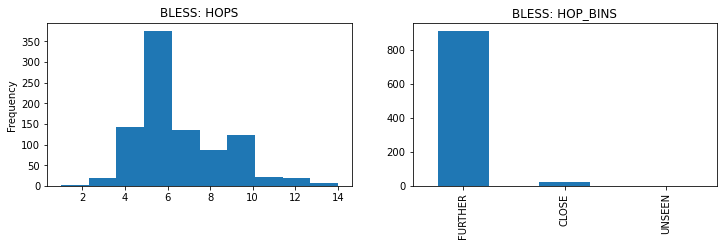

---------------------------------------- DIAG ----------------------------------------


#Hyponym in WN:  1.0
#Hypernym in WN:  1.0
#Hyponym-Hypernym in WN:  1.0
Median hops in DIAG:  6.0
Mean hops in DIAG:  6.282986111111111
Pair coverage in DIAG:  1.0


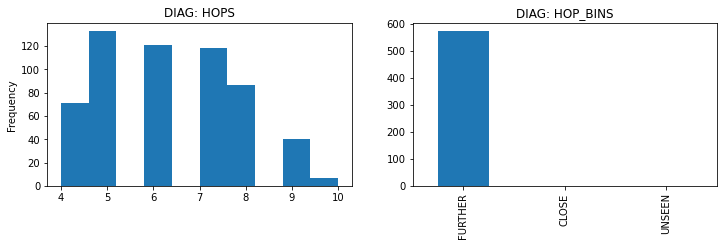

---------------------------------------- CLSB ----------------------------------------


#Hyponym in WN:  0.9759036144578314
#Hypernym in WN:  0.9990732159406858
#Hyponym-Hypernym in WN:  0.9851714550509731
Median hops in CLSB:  6.0
Mean hops in CLSB:  6.424270931326435
Pair coverage in CLSB:  0.9851714550509731


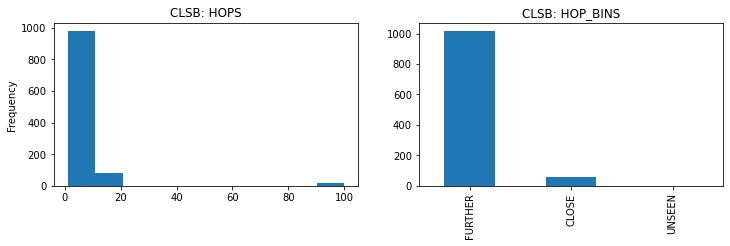

---------------------------------------- LEDS ----------------------------------------


#Hyponym in WN:  1.0
#Hypernym in WN:  1.0
#Hyponym-Hypernym in WN:  1.0
Median hops in LEDS:  5.0
Mean hops in LEDS:  5.339936608557845
Pair coverage in LEDS:  1.0


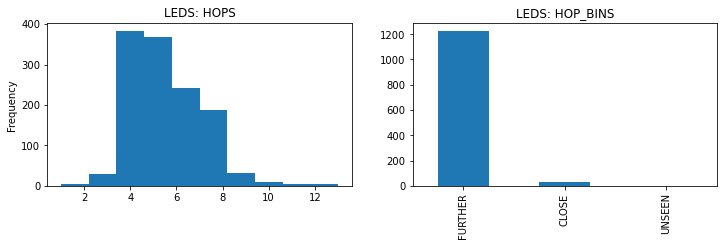

---------------------------------------- EVAL ----------------------------------------


#Hyponym in WN:  1.0
#Hypernym in WN:  0.9979013641133263
#Hyponym-Hypernym in WN:  0.9979013641133263
Median hops in EVAL:  4.0
Mean hops in EVAL:  5.076761303890642
Pair coverage in EVAL:  0.9979013641133263


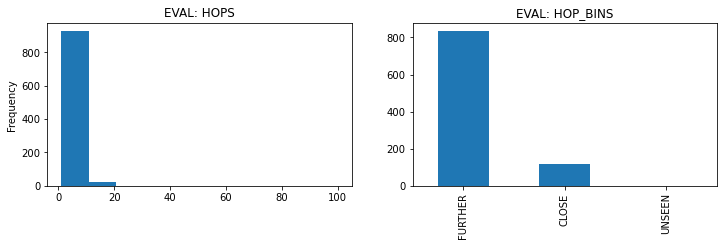

---------------------------------------- SHWARTZ ----------------------------------------


#Hyponym in WN:  0.5175259352404904
#Hypernym in WN:  0.9986639421565545
#Hyponym-Hypernym in WN:  0.4367337315309651
Median hops in SHWARTZ:  7.0
Mean hops in SHWARTZ:  7.947813568472197
Pair coverage in SHWARTZ:  0.4367337315309651


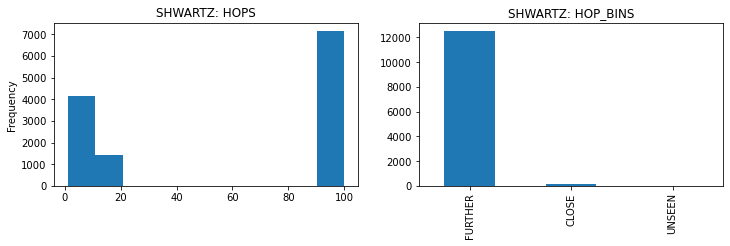

,Dataset,Hyponym,Hypernym,Pair,Median Hop,Mean Hop
0,BLESS,100.0,100.0,100.0,6.0,6.5
1,DIAG,100.0,100.0,100.0,6.0,6.3
2,CLSB,97.6,99.9,98.5,6.0,6.4
3,LEDS,100.0,100.0,100.0,5.0,5.3
4,EVAL,100.0,99.8,99.8,4.0,5.1
5,SHWARTZ,51.8,99.9,43.7,7.0,7.9


In [8]:
def bin_hops(df, cut_bins = [2] , cut_labels = ['CLOSE', 'FURTHER'],  hop_col = 'wn_hops', hop_level_col = 'wn_hops_level'):
    df[hop_col] = df[['sub_label_sg', 'obj_label_sg']].apply(lambda x: get_wordnet_shortest_path_length_between(x[0], eval(x[1])[0]), axis=1)
    
    cut_bins.append(df[hop_col].max()) #5000,
    df[hop_level_col] = pd.cut(df[hop_col], bins=cut_bins,labels=cut_labels).values.add_categories("UNSEEN")
    df[hop_level_col].fillna(value='UNSEEN', inplace=True)
    return df 

# path = '
log_dir = '../log/bert-large-uncased/'
dataset = 'lm_diagnostic_extended'
output_dir = 'analysis_rare_words/output/'
# dataset = 'DIAG'
# dataset_to_path = {"CLSB": log_dir + 'clsb/sgpl/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.CLSB.csv',
#                    'DIAG': log_dir + 'lm_diagnostic_extended/sgpl/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv',
#                 'BLESS': log_dir + 'hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 
#                    'LEDS': log_dir + 'hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_False_wnp_True_cpt_False.HYPERNYMSUITE.csv',
#             'EVAL': log_dir + 'hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.HYPERNYMSUITE.csv',
#             'SHWARTZ': log_dir + 'hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'
#            }



dataset_to_df = defaultdict()
dataset_to_stats = []
for dataset, path in dataset_to_localpath.items(): 
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12, 3)

    df = pd.read_csv(path)
    
    cut_bins = [0, 3]
    cut_labels=['CLOSE', 'FURTHER']
    hop_col = 'wn_hops'
    hop_level_col = 'wn_hops_level'
    oov_path_len = 100 
    df = bin_hops(df, cut_bins , cut_labels,  hop_col, hop_level_col)
    if len(df.query(f"{hop_level_col}=='UNSEEN'").index)>0:
        new_index = cut_labels.append('UNSEEN')
    else:
        new_index = cut_labels 
    dataset_to_df[dataset] = df 
#     display(df.query("wn_hops!=100")['wn_hops'].describe())
#     display(df.query("wn_hops!=100")['wn_hops'].quantile(0.25))

    df['sub_in_wn'] = df['sub_label_sg'].apply(lambda x: check_word_in_wordnet(x, wn_lemmas))
    df['obj_in_wn'] = df['obj_label_sg'].apply(lambda x: check_word_in_wordnet(eval(x)[0], wn_lemmas))
    df['sub_obj_in_wn'] = df[['sub_label_sg', 'obj_label_sg']].apply(lambda x: check_hypo_hyper_pair_in_wordnet(x[0], eval(x[1])[0]), axis=1)
    print("-"*40, dataset, "-"*40)
    
                                            
    display(df['wn_hops'].plot(kind='hist', ax=ax1))
    df['wn_hops_level'].value_counts().plot(kind='bar', ax=ax2)    
    ax1.set_title(f"{dataset}: HOPS" )
    ax2.set_title(f"{dataset}: HOP_BINS" )
    df_stats = df.query(f'wn_hops !={oov_path_len}')
    pair_coverage = len(df_stats.index)/len(df.index)
    
    ratio_hypon_in_wn = df['sub_in_wn'].sum()/len(df.index) 
    ratio_hyper_in_wn = df['obj_in_wn'].sum()/len(df.index) 
    ratio_hypo_hyper_in_wn = df['sub_obj_in_wn'].sum()/len(df.index) 
    median_hop = df_stats['wn_hops'].median()
    mean_hop = df_stats['wn_hops'].mean()
    print("#Hyponym in WN: ",ratio_hypon_in_wn)
    print("#Hypernym in WN: ", ratio_hyper_in_wn)
    print("#Hyponym-Hypernym in WN: ", pair_coverage)
    
    print(f"Median hops in {dataset}: ", median_hop)
    print(f"Mean hops in {dataset}: ", mean_hop)
    print(f"Pair coverage in {dataset}: ", pair_coverage)
    plt.show()
    
    dataset_to_stats.append({"Dataset": dataset , "Hyponym": ratio_hypon_in_wn*100 , "Hypernym": ratio_hyper_in_wn*100, "Pair": pair_coverage*100, "Median Hop": median_hop , "Mean Hop": mean_hop})
#     break 

dataset_to_stats = pd.DataFrame(dataset_to_stats).round(1)
display(dataset_to_stats)
dataset_to_stats.to_csv("../log/dataset_coverage_in_wordnet.csv")

In [14]:
# print(dataset_to_stats[['Dataset', 'Pair', 'Median Hop', 'Mean Hop']].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
Dataset &  Pair &  Median Hop &  Mean Hop \\
\midrule
  BLESS &  77.3 &         8.0 &       8.6 \\
 LMDIAG &  99.3 &        13.0 &      13.2 \\
   CLSB &  85.3 &         8.0 &       8.6 \\
   LEDS &  67.1 &         8.0 &       8.7 \\
   EVAL &  92.7 &         6.0 &       6.2 \\
SHWARTZ &  41.2 &         9.0 &       9.0 \\
\bottomrule
\end{tabular}



<ipython-input-14-b20a58ec57c5>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dataset_to_stats[['Dataset', 'Pair', 'Median Hop', 'Mean Hop']].to_latex(index=False))


## Evaluation

In [26]:
from evaluation import mean_average_precision, average_precision_at_k, precision_at_k, recall_at_k
def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        # label = eval(label)
        label = [label]
        
    if not isinstance(pred, list):
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 
    

def get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list, pred_col_suffix='obj_mask_'):
    '''
    evalaute model predictions in concept level, ignoring the morphology affects (singular, plural)
    '''

    p_at_x = [] #defaultdict() 
    for pred_col in pred_cols: 
        suffix = pred_col.replace(pred_col_suffix, "")
        prec_cur = defaultdict()
        prec_cur['mask_type'] = suffix
        for k in k_list: 
            df[f'p{k}_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k] if isinstance(x[1], str) else x[1][:k]), axis=1 )
            prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100

        p_at_x.append(prec_cur)  

    # aggregate the average precision across k 
    df_res = pd.DataFrame(p_at_x) #, columns=['mask_type', 'mAP'])
    df_res['relation'] = [relation]*len(df_res)
    return df_res

def get_precision_at_k(df, relation, pred_cols, label_col, k_list, pred_col_suffix='obj_mask_'):

    p_at_x = [] #defaultdict() 
    for pred_col in pred_cols: 
        suffix = pred_col.replace(pred_col_suffix, "")
        prec_cur = defaultdict()
        prec_cur['mask_type'] = suffix
        for k in k_list: 
            df[f'p{k}_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: 1 if x[0][0] in x[1][:k] else 0, axis=1 )
            prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100

            # suffix = pred_col.replace("obj_", "")
            # df[f'p@{k}_{suffix}'] = df[['obj_label', pred_col]].apply(lambda x: precision_at_k(y_true=np.array(x[0]), y_pred=np.array(x[1]), k=k), axis=1 )
            # df[f'p@{k}_{suffix}'] = df[['obj_label', pred_col]].apply(lambda x: precision_at_k(y_true=x[0], y_pred=x[1], k=k), axis=1 )

        p_at_x.append(prec_cur)  

    # aggregate the average precision across k 
    df_res = pd.DataFrame(p_at_x) #, columns=['mask_type', 'mAP'])
    df_res['relation'] = [relation]*len(df_res)
    return df_res

def get_highest_mrr_among_labels(label, pred):
    '''
    return the highest rank among the multiple labels. This is applicable to single labels as well, if we the single label is put in a list

    pred: a list of words (candidates)
    label: the true labels, which is a list (different forms of a word, e.g., singular or plurs, like animal and animals)
    '''
    mrr = 0 
    if pred is None: return mrr 

    rank_list = [ pred.index(item) + 1 for item in label if item in pred] 
    if len(rank_list)>0:
        mrr = 1/min(rank_list)

    return mrr 


def get_mrr(df, relation, pred_cols, label_col, pred_col_suffix):
    '''
    mrr is calculated based on the top_k rank, all elements in obj_col are used
    '''
    # def get_mrr_single(label, pred):
    #     '''
    #     pred: a list of words (candidates)
    #     label: the true label 
    #     '''
    #     mrr = 0 
    #     if pred is not None and label in pred:
    #         rank = pred.index(label) + 1
    #         mrr = 1/rank 
    #     return mrr 

    

    mrr = [] 
    for i, pred_col in enumerate(pred_cols):
        cur_mrr = defaultdict()
        suffix = pred_col.replace(pred_col_suffix, "")

        df[f'mrr_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: get_highest_mrr_among_labels(x[0], x[1]), axis=1 ) 
        
        cur_mrr['mask_type'] = suffix
        cur_mrr[f"mrr"] = round(df[f'mrr_{suffix}'].mean(), 3)*100
        mrr.append(cur_mrr)

    mrr_df =  pd.DataFrame(data = mrr) #, columns=['mask_type', 'mrr'])
    # mrr_df['mask_type']= mrr_df['mask_type'].apply(lambda x: x.replace(""))
    mrr_df['relation'] = relation
    return mrr_df 

In [62]:
from inflection import singularize 
from tabulate import tabulate, simple_separated_format

dataset_to_df['DIAG'].columns

relation = 'Co-Hyponym'
pred_col_suffix=''
label_col = 'sub_sister'
pred_cols = ['subj_anchors_all_sg'] #['subj_anchors']
    
out_cols =['sub_label_sg', 'obj_label', 'subj_anchors', 'sub_sister']
# for dataset, df in dataset_to_df.items():
dataset_to_df = defaultdict()
for dataset, path in dataset_to_localpath.items():
    print(dataset)
    df = pd.read_csv(path)
    print(len(df.index))
    df['sub_in_wn'] = df['sub_label_sg'].apply(lambda x: check_word_in_wordnet(x, wn_lemmas))
    
    df = df.query("sub_in_wn ==1")
    #df['obj_in_wn'] = df['obj_label_sg'].apply(lambda x: check_word_in_wordnet(eval(x)[0], wn_lemmas))
    #df['sub_obj_in_wn'] = df[['sub_label_sg', 'obj_label_sg']].apply(lambda x: check_hypo_hyper_pair_in_wordnet(x[0], eval(x[1])[0]), axis=1)
    
    #if dataset =='SHWARTZ': continue 
    #if dataset !='DIAG': continue 
    
    print("sub_in_wn: ", len(df.index))
    
    df['sub_sister'] = df['sub_sister'].apply(lambda x: eval(x))
    df['subj_anchors'] = df['subj_anchors'].apply(lambda x: eval(x))
    df['subj_anchors_all_sg'] = df['subj_anchors'].apply(lambda x: [singularize(anchor) for anchor in x])
    
    df['sub_sister_num'] = df['sub_sister'].apply(lambda x: len((x)))
    print("#sub_sister is empty: ", len(df.query('sub_sister_num==0').index))
    #print("", df.query('sub_sister_num==0')[out_cols])
                                                                
    
    df_prec_anchor = get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list=[1, 5, 10],pred_col_suffix=pred_col_suffix ) ##note that this would be super slow when top_k is large (>1000) 
    df_mrr =  get_mrr(df, relation, pred_cols, label_col, pred_col_suffix)
    df_prec_anchor['mrr'] = df_prec_anchor['mask_type'].apply(lambda x:  df_mrr.loc[df_mrr['mask_type']==x, f'mrr'].values[0])

    # add WordNet path score for evaluation 
    #anchor_wordnet_avg_path, anchor_wordnet_coverage = get_wordnet_avg_path_between_sub_and_anchors(df, oov_path_len = 100)
 
    df_prec_anchor_display = df_prec_anchor[["mask_type", "p@1", "p@5", "p@10", 'mrr']] #, "anchor_wordnet_avg_path", "anchor_wordnet_coverage" ]] #f"p@{max_anchor_num}", "relation",  
                               #"mAP@1", "mAP@5" , f"mAP@{max_anchor_num}", "recall@1", "recall@5", f"recall@{max_anchor_num}", 
                               # ]]
    df_prec_anchor['label'] = 'sub_sister'
    print(tabulate(df_prec_anchor_display, tablefmt='latex', headers=df_prec_anchor_display.columns).replace("\\", "").replace("&", "\t"))
    dataset_to_df[dataset] = df
    #display(df.columns)

BLESS
935
sub_in_wn:  935
#sub_sister is empty:  15
begin{tabular}{rlrrrr}
hline
    	 mask_type           	   p@1 	   p@5 	   p@10 	   mrr 
hline
  0 	 subj_anchors_all_sg 	    41 	  55.5 	   69.9 	  48.1 
hline
end{tabular}


Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'masked_sentences',
       'sub_sister', 'uuid', 'sub_position', 'sub_label_sg', 'sub_label_pl',
       'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap',
       'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'anchor_col_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
       'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len',
       'obj_label_

DIAG
576
sub_in_wn:  576
#sub_sister is empty:  58
begin{tabular}{rlrrrr}
hline
    	 mask_type           	   p@1 	   p@5 	   p@10 	   mrr 
hline
  0 	 subj_anchors_all_sg 	   8.7 	  16.5 	   19.8 	    12 
hline
end{tabular}


Index(['Unnamed: 0', 'masked_sentences', 'obj_label', 'sub_label',
       'sub_label_pl', 'relation', 'sub_sister', 'uuid', 'sub_position',
       'sub_label_sg', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap',
       'anchor_lsp_sap', 'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'anchor_col_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
       'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len',
       'obj_label_

CLSB
1079
sub_in_wn:  1053
#sub_sister is empty:  20
begin{tabular}{rlrrrr}
hline
    	 mask_type           	   p@1 	   p@5 	   p@10 	   mrr 
hline
  0 	 subj_anchors_all_sg 	  31.3 	  49.8 	   59.4 	  39.2 
hline
end{tabular}


Index(['Unnamed: 0', 'sub_label', 'obj_label', 'masked_sentences', 'relation',
       'weight', 'feature_type', 'obj_label_single', 'sub_sister', 'uuid',
       'sub_position', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap',
       'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_in_BERT',
       'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap',
       'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score',
       'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg',
       'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
       'mrr_subj_anchors_sg', 'mrr_anchor_col_all',

LEDS
1262
sub_in_wn:  1262
#sub_sister is empty:  21
begin{tabular}{rlrrrr}
hline
    	 mask_type           	   p@1 	   p@5 	   p@10 	   mrr 
hline
  0 	 subj_anchors_all_sg 	  22.7 	  43.2 	     53 	  31.6 
hline
end{tabular}


Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'masked_sentences',
       'sub_sister', 'uuid', 'sub_position', 'sub_label_sg', 'sub_label_pl',
       'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap',
       'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'anchor_col_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
       'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len',
       'obj_label_

EVAL
953
sub_in_wn:  953
#sub_sister is empty:  4
begin{tabular}{rlrrrr}
hline
    	 mask_type           	   p@1 	   p@5 	   p@10 	   mrr 
hline
  0 	 subj_anchors_all_sg 	  30.8 	  59.4 	   74.3 	  43.3 
hline
end{tabular}


Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'masked_sentences',
       'sub_sister', 'uuid', 'sub_position', 'sub_label_sg', 'sub_label_pl',
       'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap',
       'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'anchor_col_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
       'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len',
       'obj_label_

SHWARTZ
12724
sub_in_wn:  6585
#sub_sister is empty:  1579
begin{tabular}{rlrrrr}
hline
    	 mask_type           	   p@1 	   p@5 	   p@10 	   mrr 
hline
  0 	 subj_anchors_all_sg 	  13.1 	  28.4 	   36.8 	  19.7 
hline
end{tabular}


Index(['Unnamed: 0', 'sub_label', 'obj_label', 'relation', 'masked_sentences',
       'sub_sister', 'uuid', 'sub_position', 'sub_label_sg', 'sub_label_pl',
       'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap',
       'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence',
       'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
       'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
       'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
       'anchor_col_all', 'subj_anchors_combined',
       'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
       'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
       'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
       'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
       'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
       'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len',
       'obj_label_

## Case study

In [101]:
query = ['apple', 'car', 'corn', 'lime','train'] 
# dataset_to_df['BLESS'][['p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg']]
# .columns                 #.query(f"sub_label_sg in {query}")[['sub_label_sg','subj_anchors_sg']].drop_duplicates(keep='first') #'obj_label',
dfe = dataset_to_df['DIAG'].query("p1_subj_anchors_all_sg==0 and sub_sister_num==0")[['sub_label_sg','subj_anchors_sg', 'sub_sister']]#.drop_duplicates(keep='first') 
dfe.sample(40)

,sub_label_sg,subj_anchors_sg,sub_sister
152,horsecar,"['bus', 'carriage', 'tram', 'bicycle', 'coach']",[]
537,deodar,"['chief', 'priest', 'officer', 'soldier', 'musician']",[]
83,toucanet,"['fox', 'pigeon', 'rabbit', 'crow', 'duck']",[]
298,corkscrew,"['maybe', 'lock', 'chain', 'yes', 'knife']",[]
538,sternwheeler,"['barge', 'ferry', 'transport', 'tug', 'especially']",[]
309,salai,"['human', 'france', 'germany', 'switzerland', 'italy']",[]
189,crookneck,"['indian', 'maybe', 'yes', 'cop', 'cowboy']",[]
230,grebe,"['crow', 'penguin', 'duck', 'bird', 'fox']",[]
116,jackscrew,"['rope', 'yes', 'maybe', 'spike', 'chain']",[]
438,panzer,"['tank', 'infantry', 'gun', 'artillery', 'panther']",[]


In [75]:
query=['murre', 'carport', 'radicchio', 'panzer', 'condor']

df_sample_paper = dataset_to_df['DIAG'].query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors_sg', 'sub_sister']]
display(df_sample_paper)

df_sample_paper = df_sample_paper[['sub_label_sg', 'subj_anchors_sg', 'sub_sister']].rename(columns={"sub_label_sg": "x", 
                                                                                            "subj_anchors_sg": "z", 
                                                                                            'sub_sister': "z`" })

latex_text = df_sample_paper.to_latex(index=False, escape=False) 
latex_text = latex_text.replace("'", "").replace("[", "").replace("]", "")
print(latex_text)

,sub_label_sg,subj_anchors_sg,sub_sister
84,murre,"['dog', 'bird', 'fox', 'crow', 'rabbit']",[]
142,carport,"['garage', 'shed', 'yard', 'landscape', 'garden']",[]
380,radicchio,"['grape', 'tomato', 'mushroom', 'berry', 'apple']",[]
438,panzer,"['tank', 'infantry', 'gun', 'artillery', 'panther']",[]
563,condor,"['eagle', 'hawk', 'crow', 'owl', 'hybrid']",[buzzard]


\begin{tabular}{lll}
\toprule
        x &                                                   z &        z` \\
\midrule
    murre &            dog, bird, fox, crow, rabbit &         \\
  carport &   garage, shed, yard, landscape, garden &         \\
radicchio &   grape, tomato, mushroom, berry, apple &         \\
   panzer & tank, infantry, gun, artillery, panther &         \\
   condor &          eagle, hawk, crow, owl, hybrid & buzzard \\
\bottomrule
\end{tabular}



<ipython-input-75-8ef6b2ff3605>:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_text = df_sample_paper.to_latex(index=False, escape=False)


In [29]:
import pandas as pd 
path = '../../log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.HYPERNYMSUITE.cohyponyms.csv'
df1 = pd.read_csv(path)

# display(df1[['subj_anchors_sg','sub_sister_new']])
# query = ['apple', 'car', 'corn', 'lime','train'] 
# df1.query(f"sub_label_sg in {query}")[['sub_label_sg', 'obj_label', 'subj_anchors_sg']]

query=['apple', 'car', 'corn', 'lime', 'train']


df_sample_paper = df1.query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors_sg', 'sub_sister_new']]#.drop_duplicates(keep='first') #, 'sub_sister']]#
# display(df_sample_paper)

for x, preds, labels in zip(df_sample_paper['sub_label_sg'].to_list(), df_sample_paper['subj_anchors_sg'].to_list(), df_sample_paper['sub_sister_new'].to_list()):
    #print(type(preds), eval(preds))
    #print(type(labels), eval(labels))
    preds = eval(preds)
    labels = eval(labels)
    print(x, set(preds).intersection(set(labels)))


murre set()
carport {'shed', 'garage'}
radicchio set()
panzer {'tank'}
condor set()


In [43]:
path = '../../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.LM_DIAGNOSTIC_EXTENDED.cohyponyms.csv'
df1 = pd.read_csv(path)
# query=['murre', 'carport', 'radicchio', 'panzer', 'condor']
# df1.columns 
#display(df1.query("p5_subj_anchors_all_sg==0")[['sub_label_sg', 'obj_label', 'subj_anchors_sg', 'p5_subj_anchors_all_sg']].sample(50))

query = ['motel', 'buckboard', 'daisy']
df_sample_paper = df1.query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors_sg', 'sub_sister_new']]#.drop_duplicates(keep='first') #, 'sub_sister']]#
for x, preds, labels in zip(df_sample_paper['sub_label_sg'].to_list(), df_sample_paper['subj_anchors_sg'].to_list(), df_sample_paper['sub_sister_new'].to_list()):
    preds = eval(preds)
    labels = eval(labels)
    #print(labels)
    print(x, set(preds).intersection(set(labels)))
    print(x, preds)


buckboard set()
buckboard ['bicycle', 'bike', 'yes', 'motorcycle', 'maybe']
motel set()
motel ['hotel', 'yes', 'sure', 'restaurant', 'actually']
daisy set()
daisy ['rose', 'yes', 'lavender', 'rush', 'fern']


In [100]:
query=['apple', 'car', 'corn', 'lime', 'train']

df_sample_paper = dataset_to_df['BLESS'].query(f"sub_label_sg in {query}")[['sub_label_sg', 'subj_anchors_sg', 'sub_sister']]#.drop_duplicates(keep='first') #, 'sub_sister']]#
# display(df_sample_paper)

for x, preds, labels in zip(df_sample_paper['sub_label_sg'].to_list(), df_sample_paper['subj_anchors_sg'].to_list(), df_sample_paper['sub_sister'].to_list()):
    preds = eval(preds)
    print(x, set(preds).intersection(set(labels)))
    #print(set(eval(preds)).intersection(set(eval(labels))))
    
# df_sample_paper = df_sample_paper[['sub_label_sg', 'subj_anchors_sg', 'sub_sister']].rename(columns={"sub_label_sg": "x", 
#                                                                                             "subj_anchors_sg": "z", 
#                                                                                             'sub_sister': "z`" })

# latex_text = df_sample_paper.to_latex(index=False, escape=False) 
# latex_text = latex_text.replace("'", "").replace("[", "").replace("]", "")
# print(latex_text)


corn {'barley', 'wheat'}
apple {'date', 'grape', 'pear'}
car {'bike', 'truck', 'motorcycle'}
corn {'barley', 'wheat'}
apple {'date', 'grape', 'pear'}
car {'bike', 'truck', 'motorcycle'}
car {'bike', 'truck', 'motorcycle'}
lime {'oak'}
corn {'barley', 'wheat'}
lime {'oak'}
corn {'barley', 'wheat'}
lime {'oak'}
train {'bus'}
train {'bus'}
lime {'oak'}
train {'bus'}
corn {'barley', 'wheat'}
apple {'date', 'grape', 'pear'}
